In [9]:
!pip install hmmlearn

You should consider upgrading via the 'c:\users\jiangian\anaconda3\python.exe -m pip install --upgrade pip' command.


In [7]:
!pip install --user "snowflake-connector-python[pandas]" --upgrade 

You should consider upgrading via the 'c:\users\jiangian\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import time
from kneed import DataGenerator, KneeLocator
from sklearn.ensemble import IsolationForest
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import os
from snowflake.connector.pandas_tools import write_pandas
import snowflake.connector
import pandas as pd
from datetime import datetime
# from stock.technical import get_all_indices
from getpass import getpass
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
from itertools import combinations
import warnings
from pycaret.classification import *


#===========================================================
#====================FEATURE ENGINEERING====================
#===========================================================

def clusterize(df, cluster_num=2):
    def find_cluster_num(data, max_clusters=10):
        sse = {}
        for k in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(data)
            sse[k] = kmeans.inertia_
        kn = KneeLocator(x=list(sse.keys()), 
                  y=list(sse.values()), 
                  curve='convex', 
                  direction='decreasing')
        return kn.knee 
    df_out= df.copy()
    clust_model_dict = {}
    order_dict = {}
    for col in tqdm(df.columns):
        col_output = df[col]
        col_output = col_output.replace([np.inf, -np.inf], np.nan)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if cluster_num is None:
                cluster_num_tmp = find_cluster_num(col_output.dropna().values.reshape(-1, 1))
            else:
                cluster_num_tmp = cluster_num
            kmeans = KMeans(n_clusters=cluster_num_tmp).fit(col_output.dropna().values.reshape(-1, 1))
            clust_model_dict[col] = kmeans
            order_map = dict(zip(range(cluster_num_tmp), np.squeeze(rankdata(kmeans.cluster_centers_)).tolist()))
            col_output[~col_output.isna()] = list(map(lambda x: order_map[x], kmeans.labels_))
            order_dict[col] = order_map
        df_out[col] = col_output
    return df_out, clust_model_dict, order_dict


def get_all_indices(data_final, rolling_periods, groupby_col="Day", metrics=["std", "mean", "min", "max", "skew", "pct_change"], col_dict=None):
    if col_dict is None:
        col_dict = {m:data_final.columns.tolist() for m in metrics}
    data_out = data_final.copy()
    for metric in metrics:
        for period in rolling_periods:
            if metric in ["pct_change", "diff"]:
                if groupby_col is not None:
                    tmp = getattr(data_final[col_dict[metric]].groupby(groupby_col), metric)(periods=period).droplevel(0)
                else:
                    tmp = getattr(data_final[col_dict[metric]], metric)(periods=period)
            else:
                if groupby_col is not None:
                    tmp = getattr(data_final[col_dict[metric]].groupby(groupby_col).rolling(period, min_periods=1), metric)().droplevel(0)
                else:
                    tmp = getattr(data_final[col_dict[metric]].rolling(period, min_periods=1), metric)()
            data_out = data_out.join(tmp, lsuffix="", rsuffix="_{}_{}".format(metric, period))
    return data_out


#===============================================
#====================PYCARET====================
#===============================================

def pycaret_automl(crypto_train, crypto_test, coin, return_period, 
                   plot=True, download=False, save_folder="/content/drive/MyDrive/crypto_models",
                  pycaret_args=None):
    # Setting up environment
    # CRITICAL: Out-of-time validation scheme
    print("'target' in crypto_train: {}".format("target" in crypto_train))
    print("'target' in crypto_test: {}".format("target" in crypto_test))
    
    if pycaret_args is None:
        exp_default = setup(data=crypto_train, test_data=crypto_test, target="target", log_experiment=True, 
                            experiment_name="{}_{}".format(coin, return_period), silent=True)
    else:
        exp_default = setup(data=crypto_train, test_data=crypto_test, target="target", log_experiment=True, 
                    experiment_name="{}_{}".format(coin, return_period), silent=True, **pycaret_args)
    if save_folder is not None:
        if os.path.exists(save_folder):
            pass
        else:
            os.makedirs(save_folder)

    start_time = time.time()
    best_models = compare_models(n_select=5, sort="AUC", exclude=["gbc"])
    print("Completed in {} seconds".format(time.time() - start_time))

    for mdl in best_models:
        mld_name = "{}_{}_{}".format(coin, mdl.__class__.__name__, return_period)
        if save_folder is not None:
            if save_folder.endswith("/"):
                save_model(mdl, save_folder + mld_name)
            else:
                save_model(mdl, save_folder + "/" + mld_name)
        else:
            save_model(mdl, mld_name)
    
    if download:
        files.download(mld_name + ".pkl")    
  
    best_model = best_models[0]# Selecting best model
    best_models_blend = blend_models(best_models)

    if plot:
        print("========================================================================================================================================")
        print("===============================================================BEST MODEL===============================================================")
        print("========================================================================================================================================")
        plot_model(best_model)
        plot_model(best_model, plot="confusion_matrix")

        print("========================================================================================================================================")
        print("===============================================================BEST BLEND===============================================================")
        print("========================================================================================================================================")
        plot_model(best_models_blend)
        plot_model(best_models_blend, plot="confusion_matrix")
      
    # Finalizing best model(s)
    best_model_finalized = finalize_model(best_model)
    best_blend_finalized = finalize_model(best_models_blend)
  
    if save_folder is not None:
        if save_folder.endswith("/"):
            get_logs().to_csv(save_folder + "{}_{}_log.csv".format(coin, return_period))
            save_model(best_model_finalized, save_folder + "best_model_finalized")
            save_model(best_model_finalized, save_folder + "best_blend_finalized")
        else:
            get_logs().to_csv(save_folder + "/{}_{}_log.csv".format(coin, return_period))
            save_model(best_model_finalized, save_folder + "/best_model_finalized")
            save_model(best_model_finalized, save_folder + "/best_blend_finalized")
    else:
        save_model(best_model_finalized, "best_model_finalized")
        save_model(best_model_finalized, "best_blend_finalized")
        get_logs().to_csv("{}_{}_log.csv".format(coin, return_period))
  
    return best_models, best_model_finalized, best_blend_finalized, get_logs()

#=========================================================
#====================CROSS-CORRELATION====================
#=========================================================

def cross_corr(crypto_wide, coin1, coin2, lag):
    if lag > 0:
        return(np.corrcoef(crypto_wide.dropna(subset=[coin1, coin2])[coin1].iloc[lag:], crypto_wide.dropna(subset=[coin1, coin2])[coin2].shift(lag).dropna())[0, 1])
    elif lag < 0:
        return(np.corrcoef(crypto_wide.dropna(subset=[coin1, coin2])[coin1].iloc[:lag], crypto_wide.dropna(subset=[coin1, coin2])[coin2].shift(lag).dropna())[0, 1])
    elif lag == 0:
        return(np.corrcoef(crypto_wide.dropna(subset=[coin1, coin2])[coin1], crypto_wide.dropna(subset=[coin1, coin2])[coin2])[0, 1])


def cross_corr_range(crypto_wide, coin1, coin2, lag_range, plot=True):
    result = pd.Series(lag_range).apply(lambda x: cross_corr(crypto_wide, coin1, coin2, int(round(x))))
    result.index = lag_range
    if plot:
        plt.plot(result)
        plt.show()
    else:
        pass
    return result


def get_cross_corr_matrix(crypto_wide, price_cols, num_est = 10):
    cross_corr_mat = pd.DataFrame([], columns=price_cols, index=price_cols)
    print("Getting cross-correlations")
    print("\t", end="")
    for pair in tqdm(list(combinations(price_cols, 2))):
        cross_corr_values = cross_corr_range(crypto_wide, pair[0], pair[1], np.linspace(-2880, 2880, num=num_est), plot=False)
        greatest_result = cross_corr_values[cross_corr_values == cross_corr_values.max()]
        greatest_lag = greatest_result.index[0]
        greatest_corr = greatest_result.values[0]
        if greatest_lag < 0:
            cross_corr_mat.loc[pair[0], pair[1]] = greatest_corr
        elif greatest_lag > 0:
            cross_corr_mat.loc[pair[1], pair[0]] = greatest_corr
        else:
            pass
    return cross_corr_mat.astype(float)


def get_split_dates(crypto_wide, num_weeks_train, num_weeks_test, num_weeks_holdout):
    # Defining our periods of interest
    holdout_start = crypto_wide.index.max() - pd.Timedelta(weeks=num_weeks_holdout)
    test_start = holdout_start - pd.Timedelta(weeks=num_weeks_test)
    train_start = test_start - pd.Timedelta(weeks=num_weeks_train)
    print("Number of training samples: {}".format(((crypto_wide.index < test_start) & (crypto_wide.index >= train_start)).sum()))
    print("Number of test samples: {}".format(((crypto_wide.index >= test_start) & (crypto_wide.index < holdout_start)).sum()))
    print("Number of holdout samples: {}".format(((crypto_wide.index >= holdout_start)).sum()))
    return train_start, test_start, holdout_start


def prepare_data(crypto_wide, coin_of_interest, columns_of_interest, train_start, test_start, holdout_start, cluster_num=None, 
                  cross_correlation_matrix=None, cross_corr_thresh=0.50, outlier_column=False):
    all_coins = [coin_of_interest]

    # Yielding our testing/training/holdout dataframes
    crypto_train = crypto_wide.loc[train_start:test_start]
    crypto_test = crypto_wide.loc[test_start:holdout_start]
    crypto_holdout = crypto_wide.loc[holdout_start:]
    crypto_test_holdout = pd.concat([crypto_test, crypto_holdout])

    # Getting clusters for each coin return
    print("Fitting clusters on training data")
    print("\t", end="")
    cluster_cols = [col for col in crypto_train if "{}_pct_change".format(coin_of_interest) in col]
    crypto_return_clusters_train, cluster_model_dict, order_dict = clusterize(crypto_wide.loc[train_start:test_start, cluster_cols], cluster_num=cluster_num)
#     crypto_return_clusters_train = crypto_return_clusters_train.loc[train_start:]
    crypto_return_clusters_test_holdout = crypto_test_holdout[cluster_cols].copy()

    print("Predicting clusters on test and holdout data")
    print("\t", end="")
    for col in tqdm(cluster_cols):
        kmean_labels = cluster_model_dict[col].predict(crypto_return_clusters_test_holdout[col].values.reshape(-1, 1))
        crypto_return_clusters_test_holdout[col] = list(map(lambda x: order_dict[col][x], kmean_labels))
    
    crypto_return_clusters_train = crypto_return_clusters_train.astype(int).astype(str)
    crypto_return_clusters_test_holdout = crypto_return_clusters_test_holdout.astype(int).astype(str)
    crypto_train = crypto_train.join(crypto_return_clusters_train, lsuffix="", rsuffix="_clust")
    crypto_test_holdout = crypto_test_holdout.join(crypto_return_clusters_test_holdout, lsuffix="", rsuffix="_clust")
    columns_of_interest += [col for col in crypto_train if "clust" in col]
  
    # Adding coin data for potentially causal coins
    if cross_correlation_matrix is not None:
        print("Getting additional potentially influential coins")
        print("\t", end="")
        additional_coins = (cross_correlation_matrix.abs() > cross_corr_thresh).query(coin_of_interest).index.tolist()
        all_coins += additional_coins
        additional_cols = []
        for coin in tqdm(additional_coins):
            additional_cols += [col for col in crypto_train if coin in col]
        columns_of_interest += additional_cols
        columns_of_interest = list(set(columns_of_interest))
    else:
        pass
  
    # Getting coin-based outliers
    if outlier_column:
        print("Getting outliers")
        print("\t", end="")
        for coin in tqdm(all_coins):
            # Getting coin-related columns to create outlier computation
            coin_cols = [col for col in crypto_wide if coin in col]

            # training the model
            clf = IsolationForest(max_samples=100, random_state=1)
            clf.fit(crypto_train[coin_cols].dropna().values)
            train_outliers = clf.predict(crypto_train[coin_cols].dropna().values)
            outlier_col = "{}_OUTLIER".format(coin)
            columns_of_interest += [outlier_col]
            crypto_train[outlier_col] = np.nan
            crypto_train.loc[~crypto_train[coin_cols].isna().any(axis=1), outlier_col] = train_outliers.astype(int).astype(str)

            # predicting model on test/holdout partitions
            test_outliers = clf.predict(crypto_test_holdout[coin_cols].dropna().values)
            crypto_test_holdout[outlier_col] = np.nan
            crypto_test_holdout.loc[~crypto_test_holdout[coin_cols].isna().any(axis=1), outlier_col] = test_outliers.astype(int).astype(str)
  
    # Selecting only our columns of interest
    crypto_train = crypto_train[columns_of_interest]
    crypto_test_holdout = crypto_test_holdout[columns_of_interest]
    return crypto_train, crypto_test_holdout, crypto_return_clusters_train, crypto_return_clusters_test_holdout


def add_target(coin_of_interest, crypto_train, crypto_test_holdout, return_period, test_start):
    # Joining on clusters of our coin returns
    target = "{}_pct_change_{}".format(coin_of_interest, return_period)
    combined_df = pd.concat([crypto_train, crypto_test_holdout])
    combined_cluster_df = pd.concat([crypto_return_clusters_train, crypto_return_clusters_test_holdout])
    combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
    combined_cluster_df = combined_cluster_df[~combined_cluster_df.index.duplicated(keep='first')]
    combined_df["target"] = combined_cluster_df[target].shift(-return_period)
    crypto_train, crypto_test_holdout = combined_df.loc[:test_start], combined_df.loc[test_start:]
    cluster_desc = crypto_train.groupby(crypto_return_clusters_train[target])[[target]].describe()
    print("Unique values of target: {}".format(crypto_train["target"].nunique()))
    return crypto_train, crypto_test_holdout, cluster_desc


def split_df(crypto_train, crypto_test_holdout, holdout_start):
    # Further partitioning our combined test/holdout dataframe
    crypto_test, crypto_holdout = crypto_test_holdout.loc[:holdout_start].dropna(subset=["target"]), crypto_test_holdout.loc[holdout_start:].dropna(subset=["target"])

    # Converting target to string for classification task
    crypto_train["target"] = crypto_train["target"].astype(int).astype(str)
    crypto_test["target"] = crypto_test["target"].astype(int).astype(str)
    crypto_test["target"] = crypto_test["target"].astype(int).astype(str)
    return crypto_train, crypto_test, crypto_holdout

In [3]:
username = getpass("username: ")
password = getpass("password: ")

# Reading in data from snowflake
conn  = snowflake.connector.connect(user=username,
                                   password=password,
                                   account="kga72450.us-east-1")

conn.cursor().execute("USE WAREHOUSE COMPUTE_WH")
conn.cursor().execute("USE DATABASE CRYPTO")

cur = conn.cursor()

sql = "select * from TOP_CRYPTO_YTD"
cur.execute(sql)
crypto_df = cur.fetch_pandas_all()

# Converting types
crypto_df = crypto_df.astype({col:float for col in crypto_df.columns if col not in ["NA", "COIN"]})

# Converting timestamps to date-time
convert_time = lambda x: datetime.fromtimestamp(x/1000)# Convert from millisecond to second
crypto_df["OPEN_TIME"] = crypto_df["OPEN_TIME"].apply(convert_time)
crypto_df["CLOSE TIME"] = crypto_df["CLOSE TIME"].apply(convert_time)

# Pivoting columns to wide
crypto_open = crypto_df.pivot_table(columns=["COIN"], index=["OPEN_TIME"], values=["OPEN"])["OPEN"]
crypto_volume = crypto_df.pivot_table(columns=["COIN"], index=["OPEN_TIME"], values=["VOLUME"])["VOLUME"]
crypto_num_trade = crypto_df.pivot_table(columns=["COIN"], index=["OPEN_TIME"], values=["NUMBER_OF_TRADES"])["NUMBER_OF_TRADES"]

crypto_seed_df = crypto_open.join(crypto_volume.join(crypto_num_trade, lsuffix="_VOLUME", rsuffix="_NUM_TRADES"))# Joining everything together
volume_cols = [col for col in crypto_seed_df if "VOLUME" in col]
num_trades_cols = [col for col in crypto_seed_df if "NUM_TRADES" in col]
price_cols = [col for col in crypto_seed_df if col.endswith("USDT")]

# Getting data with all the indices for analysis
crypto_wide = get_all_indices(crypto_seed_df, rolling_periods=[1, 5, 10, 60, 180], groupby_col=None, metrics=["pct_change", "diff"], 
                              col_dict={"pct_change":price_cols, "diff":(num_trades_cols + volume_cols)})
crypto_wide = crypto_wide.reset_index().rename(columns={"OPEN_TIME":"Time"}).set_index("Time")

del crypto_seed_df, crypto_num_trade, crypto_volume, crypto_open

username: ········
password: ········


In [4]:
num_weeks_train, num_weeks_test, num_weeks_holdout = 4, 1, 1
train_start, test_start, holdout_start = get_split_dates(crypto_wide, num_weeks_train, num_weeks_test, num_weeks_holdout)
cross_corr_mat = get_cross_corr_matrix(crypto_wide.loc[train_start:test_start], price_cols, num_est=10)

for coin_of_interest in (set(price_cols)-{"AVAXUSDT"}):
# for coin_of_interest in ["AVAXUSDT"]:
    crypto_train, crypto_test_holdout, crypto_return_clusters_train, crypto_return_clusters_test_holdout = prepare_data(crypto_wide, coin_of_interest, [col for col in crypto_wide if ("BTCUSDT" in col) or ("ETHUSDT" in col) or (coin_of_interest in col)], train_start=train_start, test_start=test_start, holdout_start=holdout_start, cluster_num=None, 
                      cross_correlation_matrix=cross_corr_mat, cross_corr_thresh=0.50, outlier_column=True)
    return_periods = [1, 5, 10, 60, 180]
#     return_periods = [5]
    test_args = {"fold_strategy":"timeseries", "create_clusters":True}

    for return_period in return_periods:
        crypto_train_tmp, crypto_test_holdout_tmp, cluster_desc = add_target(coin_of_interest, crypto_train, crypto_test_holdout, return_period, test_start)
        crypto_train_tmp, crypto_test_tmp, crypto_holdout_tmp = split_df(crypto_train_tmp, crypto_test_holdout_tmp, holdout_start)
        best_models, best_model_finalized, best_blend_finalized, logs = pycaret_automl(crypto_train_tmp, crypto_test_tmp, coin_of_interest, return_period, plot=False, download=False, save_folder="./crypto_models/{}/{}".format(coin_of_interest, return_period),
                                                                                      pycaret_args=test_args)

Number of training samples: 40320
Number of test samples: 10080
Number of holdout samples: 10081
Getting cross-correlations
	

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [05:14<00:00,  3.46s/it]


Fitting clusters on training data
	

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.34s/it]


Predicting clusters on test and holdout data
	

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Getting additional potentially influential coins
	

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 6232.25it/s]


Getting outliers
	

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:11<00:00, 10.17s/it]


Unique values of target: 3


In [13]:
crypto_train_hmm = crypto_train_tmp[[col for col in crypto_train_tmp if "clust" in col] + ["target"]]
crypto_test_hmm = crypto_test_tmp[[col for col in crypto_test_tmp if "clust" in col] + ["target"]]

crypto_train_hmm.to_csv("crypto_train_hmm.csv", index=False)
crypto_test_hmm.to_csv("crypto_test_hmm.csv", index=False)

In [3]:
from hmmsupervised import HMMClassifier
import importlib as imp
from itertools import product

crypto_train_hmm = pd.read_csv("crypto_train_hmm.csv").astype(str)
crypto_test_hmm = pd.read_csv("crypto_test_hmm.csv").astype(str)

In [41]:
hmmclass = HMMClassifier(n_components=20, mode="cat")
hmmclass.fit(crypto_train_hmm.drop(columns=["target"]), crypto_train_hmm["target"], epsilon=0.1)

display(hmmclass.state_prob.sort_index(axis=1))

y_pred = hmmclass.predict(crypto_test_hmm.drop(columns=["target"]))
y_probs = hmmclass.predict_proba(crypto_test_hmm.drop(columns=["target"]))
y_test = crypto_test_hmm["target"]

,"(1, 1, 1, 1, 1, 1)","(1, 1, 1, 1, 1, 2)","(1, 1, 1, 1, 1, 3)","(1, 1, 1, 1, 2, 1)","(1, 1, 1, 1, 2, 2)","(1, 1, 1, 1, 2, 3)","(1, 1, 1, 1, 3, 1)","(1, 1, 1, 1, 3, 2)","(1, 1, 1, 1, 3, 3)","(1, 1, 1, 2, 1, 1)","(1, 1, 1, 2, 1, 2)","(1, 1, 1, 2, 1, 3)","(1, 1, 1, 2, 2, 1)","(1, 1, 1, 2, 2, 2)","(1, 1, 1, 2, 2, 3)","(1, 1, 1, 2, 3, 1)","(1, 1, 1, 2, 3, 2)","(1, 1, 1, 2, 3, 3)","(1, 1, 1, 3, 1, 1)","(1, 1, 1, 3, 1, 2)","(1, 1, 1, 3, 1, 3)","(1, 1, 1, 3, 2, 1)","(1, 1, 1, 3, 2, 2)","(1, 1, 1, 3, 2, 3)","(1, 1, 1, 3, 3, 1)","(1, 1, 1, 3, 3, 2)","(1, 1, 1, 3, 3, 3)","(1, 1, 2, 1, 1, 1)","(1, 1, 2, 1, 1, 2)","(1, 1, 2, 1, 1, 3)","(1, 1, 2, 1, 2, 1)","(1, 1, 2, 1, 2, 2)","(1, 1, 2, 1, 2, 3)","(1, 1, 2, 1, 3, 1)","(1, 1, 2, 1, 3, 2)","(1, 1, 2, 1, 3, 3)","(1, 1, 2, 2, 1, 1)","(1, 1, 2, 2, 1, 2)","(1, 1, 2, 2, 1, 3)","(1, 1, 2, 2, 2, 1)","(1, 1, 2, 2, 2, 2)","(1, 1, 2, 2, 2, 3)","(1, 1, 2, 2, 3, 1)","(1, 1, 2, 2, 3, 2)","(1, 1, 2, 2, 3, 3)","(1, 1, 2, 3, 1, 1)","(1, 1, 2, 3, 1, 2)","(1, 1, 2, 3, 1, 3)","(1, 1, 2, 3, 2, 1)","(1, 1, 2, 3, 2, 2)","(1, 1, 2, 3, 2, 3)","(1, 1, 2, 3, 3, 1)","(1, 1, 2, 3, 3, 2)","(1, 1, 2, 3, 3, 3)","(1, 1, 3, 1, 1, 1)","(1, 1, 3, 1, 1, 2)","(1, 1, 3, 1, 1, 3)","(1, 1, 3, 1, 2, 1)","(1, 1, 3, 1, 2, 2)","(1, 1, 3, 1, 2, 3)","(1, 1, 3, 1, 3, 1)","(1, 1, 3, 1, 3, 2)","(1, 1, 3, 1, 3, 3)","(1, 1, 3, 2, 1, 1)","(1, 1, 3, 2, 1, 2)","(1, 1, 3, 2, 1, 3)","(1, 1, 3, 2, 2, 1)","(1, 1, 3, 2, 2, 2)","(1, 1, 3, 2, 2, 3)","(1, 1, 3, 2, 3, 1)","(1, 1, 3, 2, 3, 2)","(1, 1, 3, 2, 3, 3)","(1, 1, 3, 3, 1, 1)","(1, 1, 3, 3, 1, 2)","(1, 1, 3, 3, 1, 3)","(1, 1, 3, 3, 2, 1)","(1, 1, 3, 3, 2, 2)","(1, 1, 3, 3, 2, 3)","(1, 1, 3, 3, 3, 1)","(1, 1, 3, 3, 3, 2)","(1, 1, 3, 3, 3, 3)","(1, 2, 1, 1, 1, 1)","(1, 2, 1, 1, 1, 2)","(1, 2, 1, 1, 1, 3)","(1, 2, 1, 1, 2, 1)","(1, 2, 1, 1, 2, 2)","(1, 2, 1, 1, 2, 3)","(1, 2, 1, 1, 3, 1)","(1, 2, 1, 1, 3, 2)","(1, 2, 1, 1, 3, 3)","(1, 2, 1, 2, 1, 1)","(1, 2, 1, 2, 1, 2)","(1, 2, 1, 2, 1, 3)","(1, 2, 1, 2, 2, 1)","(1, 2, 1, 2, 2, 2)","(1, 2, 1, 2, 2, 3)","(1, 2, 1, 2, 3, 1)","(1, 2, 1, 2, 3, 2)","(1, 2, 1, 2, 3, 3)","(1, 2, 1, 3, 1, 1)","(1, 2, 1, 3, 1, 2)","(1, 2, 1, 3, 1, 3)","(1, 2, 1, 3, 2, 1)","(1, 2, 1, 3, 2, 2)","(1, 2, 1, 3, 2, 3)","(1, 2, 1, 3, 3, 1)","(1, 2, 1, 3, 3, 2)","(1, 2, 1, 3, 3, 3)","(1, 2, 2, 1, 1, 1)","(1, 2, 2, 1, 1, 2)","(1, 2, 2, 1, 1, 3)","(1, 2, 2, 1, 2, 1)","(1, 2, 2, 1, 2, 2)","(1, 2, 2, 1, 2, 3)","(1, 2, 2, 1, 3, 1)","(1, 2, 2, 1, 3, 2)","(1, 2, 2, 1, 3, 3)","(1, 2, 2, 2, 1, 1)","(1, 2, 2, 2, 1, 2)","(1, 2, 2, 2, 1, 3)","(1, 2, 2, 2, 2, 1)","(1, 2, 2, 2, 2, 2)","(1, 2, 2, 2, 2, 3)","(1, 2, 2, 2, 3, 1)","(1, 2, 2, 2, 3, 2)","(1, 2, 2, 2, 3, 3)","(1, 2, 2, 3, 1, 1)","(1, 2, 2, 3, 1, 2)","(1, 2, 2, 3, 1, 3)","(1, 2, 2, 3, 2, 1)","(1, 2, 2, 3, 2, 2)","(1, 2, 2, 3, 2, 3)","(1, 2, 2, 3, 3, 1)","(1, 2, 2, 3, 3, 2)","(1, 2, 2, 3, 3, 3)","(1, 2, 3, 1, 1, 1)","(1, 2, 3, 1, 1, 2)","(1, 2, 3, 1, 1, 3)","(1, 2, 3, 1, 2, 1)","(1, 2, 3, 1, 2, 2)","(1, 2, 3, 1, 2, 3)","(1, 2, 3, 1, 3, 1)","(1, 2, 3, 1, 3, 2)","(1, 2, 3, 1, 3, 3)","(1, 2, 3, 2, 1, 1)","(1, 2, 3, 2, 1, 2)","(1, 2, 3, 2, 1, 3)","(1, 2, 3, 2, 2, 1)","(1, 2, 3, 2, 2, 2)","(1, 2, 3, 2, 2, 3)","(1, 2, 3, 2, 3, 1)","(1, 2, 3, 2, 3, 2)","(1, 2, 3, 2, 3, 3)","(1, 2, 3, 3, 1, 1)","(1, 2, 3, 3, 1, 2)","(1, 2, 3, 3, 1, 3)","(1, 2, 3, 3, 2, 1)","(1, 2, 3, 3, 2, 2)","(1, 2, 3, 3, 2, 3)","(1, 2, 3, 3, 3, 1)","(1, 2, 3, 3, 3, 2)","(1, 2, 3, 3, 3, 3)","(1, 3, 1, 1, 1, 1)","(1, 3, 1, 1, 1, 2)","(1, 3, 1, 1, 1, 3)","(1, 3, 1, 1, 2, 1)","(1, 3, 1, 1, 2, 2)","(1, 3, 1, 1, 2, 3)","(1, 3, 1, 1, 3, 1)","(1, 3, 1, 1, 3, 2)","(1, 3, 1, 1, 3, 3)","(1, 3, 1, 2, 1, 1)","(1, 3, 1, 2, 1, 2)","(1, 3, 1, 2, 1, 3)","(1, 3, 1, 2, 2, 1)","(1, 3, 1, 2, 2, 2)","(1, 3, 1, 2, 2, 3)","(1, 3, 1, 2, 3, 1)","(1, 3, 1, 2, 3, 2)","(1, 3, 1, 2, 3, 3)","(1, 3, 1, 3, 1, 1)","(1, 3, 1, 3, 1, 2)","(1, 3, 1, 3, 1, 3)","(1, 3, 1, 3, 2, 1)","(1, 3, 1, 3, 2, 2)","(1, 3, 1, 3, 2, 3)","(1, 3, 1, 3, 3, 1)","(1, 3, 1, 3, 3, 2)","(1, 3, 1, 3, 3, 3)","(1, 3, 2, 1, 1, 1)","(1, 3, 2

In [42]:
pd.Series(y_pred).value_counts()

2    8469
1     920
3     692
dtype: int64

In [19]:
y_test.value_counts()

2    5145
1    2857
3    2079
Name: target, dtype: int64

In [43]:
y_probs

array([[0.00299243, 0.04201832, 0.01869773],
       [0.00486912, 0.04359405, 0.01508191],
       [0.00368606, 0.00900746, 0.00618113],
       ...,
       [0.03710047, 0.07102263, 0.02982219],
       [0.05481537, 0.07049512, 0.03598757],
       [0.05481537, 0.07049512, 0.03598757]])

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [46]:
((y_probs[:, 0] > 0.05) == (y_test.values == 0)).mean()

0.7674833845848626

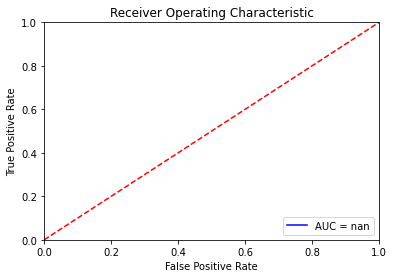

In [47]:
fpr, tpr, threshold = metrics.roc_curve((y_test.values == 0).astype(float), y_probs[:, 0])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()